Mass-Spring-Damper Model Estimation
-----------------------------------

### System Description

This is a really simple model: A 1-DOF mass-spring-damper system.

In [64]:
from IPython.display import Image

Image(url='https://github.com/stuckeyr/msd/raw/master/mass_spring_damper.png')

See [here](http://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=SystemModeling#5) for a more detailed explanation.

The equations of motion can be written:

$$
\sum F_x = F(t) - b \dot{x} - kx = m \ddot{x}
$$

where $x$ is the displacement, $m$ is the mass, $k$ is the spring constant, $b$ is the damping constant and $F$ is the input force, expressed here as a function of time.

Reframing the system in state-space form, using the state vector:

$$
\mathbf{x} = \begin{bmatrix} x \\\ \dot{x} \end{bmatrix}
$$

the equations are written:

$$
m \mathbf{\dot{x}} = \begin{bmatrix} \dot{x} \\\ \ddot{x} \end{bmatrix} = \begin{bmatrix} 0 & m \\\ -k & -b \end{bmatrix} \begin{bmatrix} x \\\ \dot{x} \end{bmatrix} + \begin{bmatrix} 0 \\\ 1 \end{bmatrix} F(t)
$$

### Simulation in Python 

First, reset the workspace. Import all necessary libraries (the following assumes you have built both Boost and Cython models).

In [6]:
%matplotlib notebook

In [1]:
%reset -f

In [3]:
import sys
import numpy as np
import numpy.matlib as ml
from msd import MSD, MSD_BOOST
from msdc import MSD_CYTHON

Create the model. Simulate and add (Gaussian) noise to the output.

In [4]:
# Observation and state noise standard deviations
NOISE_SD = [ 0.01 for _ in range(3) ]
STATE_NOISE_SD = 0.0

VERBOSE = False

# I am going to use the Cython model here, as the Python model is very slow!
MODEL = 'cython' # ['python', 'cython', 'boost']

# Zero the RNG seed
np.random.seed(1)

# Initial system state and external force input
x0 = np.zeros((2, ))
d0 = 0.0

# Sample period
dt = 0.01

# Create the time vector
T = np.arange(0.0, 15.0, dt)
N = T.shape[0]

# Create the predefined external force vector
D = ml.repmat(d0, N, 1)

T_S = [ t_s + t_ds for t_s in np.arange(0.0, 15.0, 3.0) for t_ds in [ 0.0, 1.0 ] ]
T_S.append(T[N - 1])
N_S = len(T_S)
D_S = [ d0 + d_ds for t_s in np.arange(0.0, 15.0, 3.0) for d_ds in [ 1.0, 0.0 ] ]
D_S.append(d0)

for t_i in range(0, N_S - 1, 2):
    # D[np.logical_and((T >= t_s), (T < t_s + 1.0)), 0] = d0 + np.random.randint(-2, 3)*1.0
    D[np.logical_and((T >= T_S[t_i]), (T < T_S[t_i + 1])), 0] = d0 + 1.0

if (MODEL == 'boost'):
    # Create the model (Boost extension)
    msd = MSD_BOOST("Mass-Spring-Damper_FMIN_EST", N)
    msd.set_external_forces(T_S, D_S, 'zero')
elif (MODEL == 'cython'):
    # Create the model (Boost extension)
    msd = MSD_CYTHON("Mass-Spring-Damper_FMIN_EST")
    msd.set_external_forces(T_S, D_S, 'zero')
else:
    # Create the model (pure Python)
    msd = MSD("Mass-Spring-Damper_FMIN_EST")
    msd.set_external_forces(T_S, D_S, 'zero')

# Identification keys
c_idx = ['k', 'b', 'd']

# True parameter set
CT = np.array([ msd.get_coeffs()[ck] for ck in c_idx ])

# Initial parameter set
C0 = np.array([ 0.5*msd.get_coeffs()[ck] for ck in c_idx ])

# Initial parameter dict
CD = dict(zip(c_idx, C0))

if (STATE_NOISE_SD > 0.0):
    sdw = STATE_NOISE_SD
    W = np.random.randn(N, 1)*sdw
    msd.add_state_noise(T, W)

# Compute the response
X, Xdot, F = msd.integrate(x0, T)

sys.stdout.write("\n")

# Measured state, state rate, external force input and force matrices
sdz = np.zeros((len(x0),))

if any(w > 0.0 for w in NOISE_SD[:2]):
    sdz = np.array(NOISE_SD[:2])

Z = X + np.random.randn(N, len(x0))*sdz
z0 = x0

Nu = Z[:,1]
sdnu = sdz[1]

sdzdot = np.zeros((len(x0),))
if any(w > 0.0 for w in NOISE_SD[:2]):
    sdzdot = np.array(NOISE_SD[:2])
    # sdzdot = np.array([ 0.1, 0.1 ])*0.01
Zdot = Xdot + np.random.randn(N, len(x0))*sdzdot

sde = 0.0
if (NOISE_SD[2] > 0.0):
    sde = NOISE_SD[2]
E = D + np.random.randn(N, 1)*sde
e0 = d0

G = F.copy()
sdg = 0.0
if any(w > 0.0 for w in NOISE_SD):
    # Forces are calculated from (measured) accelerations, not measured directly
    for n in range(N):
        G[n] = msd.forces(Zdot[n], Z[n])
    sdg = np.std(F - G)

Plot the measured response and control input.

In [10]:
import matplotlib.pyplot as pp

<IPython.core.display.Javascript object>


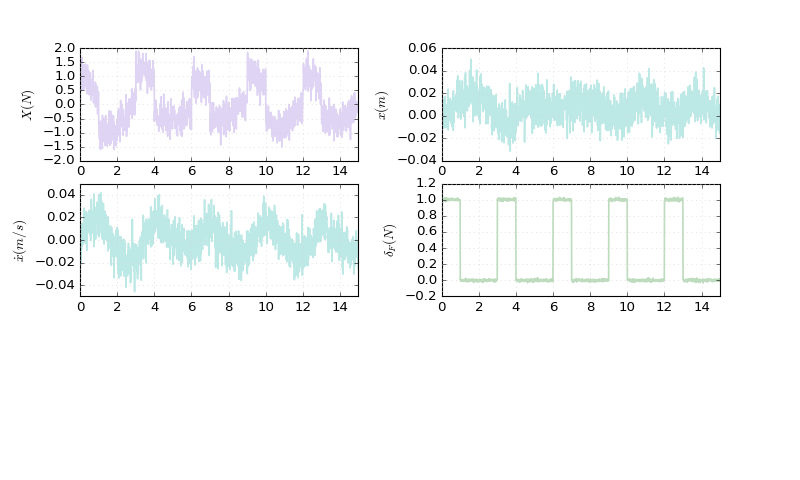

In [14]:
x_str = [ r'$x (m)$', r'$\dot x (m/s)$' ]
x_fac = [ 1.0, 1.0 ]
d_str = [ r'$\delta_F (N)$' ]
d_fac = [ 1.0 ]
f_str = [ r'$X (N)$' ]
f_fac = [ 1.0 ]
ff_str = [ r'ln ${\Delta X}^2 (N^2)$' ]

nc = 2 # number of columns
nr = 3 # number of rows

fig, AxesArr = pp.subplots(nr, nc, figsize=(10.0, 6.0))

Axes = np.ravel(AxesArr)

ax = Axes[0]
ax.grid(color='lightgrey', linestyle=':')
ax.plot(T, G*f_fac[0], color='#DFD4F4', linestyle='-', linewidth=1.5)
ax.set_xlim(T[0], T[N - 1])
ax.autoscale(enable=False)
ax.set_ylabel(f_str[0])

for j in range(2):
    ax = Axes[j + 1]
    ax.grid(color='lightgrey', linestyle=':')
    ax.plot(T, Z[:,j]*x_fac[j], color='#BCE8E6', linestyle='-', linewidth=1.5)
    ax.set_xlim(T[0], T[N - 1])
    ax.autoscale(enable=False)
    ax.set_ylabel(x_str[j])

ax = Axes[3]
ax.grid(color='lightgrey', linestyle=':')
ax.plot(T, E*d_fac[0], color='#BDDCBD', linestyle='-', linewidth=1.5)
ax.set_xlim(T[0], T[N - 1])
ax.autoscale(enable=False)
ax.set_ylabel(d_str[0])

pp.subplots_adjust(left=0.10, wspace=0.3)

fig.delaxes(Axes[4])
fig.delaxes(Axes[5])

#fig.canvas.show()

### Least-Squares Estimation

Perform a Least-Squares estimation on the measured system.

In [15]:
from scipy import linalg, stats

In [28]:
FF = ml.repmat(None, 50, 1)

print "LINEAR REGRESSION:"

if (MODEL == 'boost'):
    # Create the model (Boost extension)
    msd_est = MSD_BOOST("Mass-Spring-Damper_FMIN_EST (Boost)", N)
    msd_est.set_external_forces(T, E, 'linear_uniform')
elif (MODEL == 'cython'):
    # Create the model (Boost extension)
    msd_est = MSD_CYTHON("Mass-Spring-Damper_FMIN_EST (Cython)")
    msd_est.set_external_forces(T, E, 'linear_uniform')
else:
    # Create the model (pure Python)
    msd_est = MSD("Mass-Spring-Damper_FMIN_EST")
    msd_est.set_external_forces(T, E, 'linear')

A = np.c_[Z[:,0],Zdot[:,0],E[:,0]]

# Least squares solution
C, resid, rank, sigma = linalg.lstsq(A, G)

sigma2 = np.sum((G - np.dot(A, C))**2.0)/(N - len(c_idx)) # RMSE

cov = sigma2*np.linalg.inv(np.dot(A.T, A)) # covariance matrix
se = np.sqrt(np.diag(cov)) # standard error

alpha = 0.05
conf = 100.0*(1.0 - alpha) # confidence level

sT = stats.distributions.t.ppf(1.0 - alpha/2.0, N - len(c_idx)) # student T multiplier
CI = sT*se

SS_tot = np.sum((G - np.mean(G))**2.0)
SS_err = np.sum((np.dot(A, C) - G)**2)

#  http://en.wikipedia.org/wiki/Coefficient_of_determination
Rsq = 1.0 - SS_err/SS_tot

print "            TRUE       EST    {:2.0f}% CONF".format(conf)
for i in range(len(c_idx)):
    print "{:5s}: {:10.4f} {:10.4f} +/-{:-.4f}".format(c_idx[i], msd.C[c_idx[i]], C[i, 0], CI[i])

print "R^2 = %.4f" % Rsq

for i in range(len(c_idx)):
    msd_est.C[c_idx[i]] = C[i, 0]

# Estimated force matrix
H = np.dot(A, C)

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T)

LINEAR REGRESSION:
            TRUE       EST    95% CONF
k    :   -50.0000   -22.3785 +/-1.7482
b    :   -10.0000    -3.9897 +/-1.5943
d    :     1.0000     0.9598 +/-0.0421
R^2 = 0.6224


That's pretty good. Let's see how the estimated system response compares.

In [32]:
from plot import plot

In [33]:
fig, Axes, Lines, Text = plot(msd_est.name, T, E, Z, G, Xe=Xe, Fe=Fe)
fig.delaxes(Axes[4])
fig.delaxes(Axes[5])

<IPython.core.display.Javascript object>

IndexError: tuple index out of range

Nice. Ok, now let's increase the amount of noise on the state & state rate by 10.

In [71]:
if ADD_NOISE:
    sdz = np.array([ 0.1, 0.1 ])*0.1
    Z = X + np.random.randn(N, len(x0))*sdz

    sdzdot = np.array([ 0.1, 0.1 ])*0.1
    Zdot = Xdot + np.random.randn(N, len(x0))*sdzdot

for n in range(N):
    G[n] = msd.forces(Zdot[n], Z[n])
sdg = np.std(F - G)

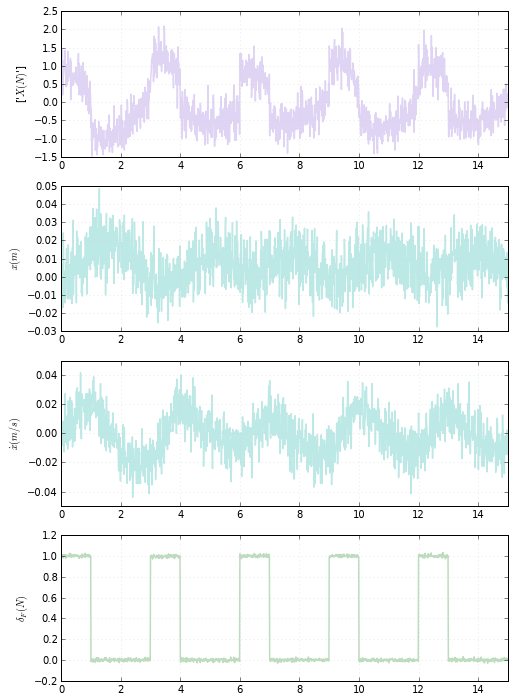

In [72]:
Axes, Lines = plot(msd.name, T, E, Z, G)

And perform a Least-Squares estimation again. The code here is exactly the same as above.

In [73]:
A = np.c_[Z[:,0],Zdot[:,0],E[:,0]]

# Least squares solution
( C, resid, rank, sigma ) = linalg.lstsq(A, G)

sigma2 = np.sum((G - np.dot(A, C))**2.0)/(N - len(c_idx)) # RMSE

cov = sigma2*np.linalg.inv(np.dot(A.T, A)) # covariance matrix
se = np.sqrt(np.diag(cov)) # standard error

alpha = 0.05
conf = 100.0*(1.0 - alpha) # confidence level

sT = stats.distributions.t.ppf(1.0 - alpha/2.0, N - len(c_idx)) # student T multiplier
CI = sT*se

SS_tot = np.sum((G - np.mean(G))**2.0)
SS_err = np.sum((np.dot(A, C) - G)**2)

#  http://en.wikipedia.org/wiki/Coefficient_of_determination
Rsq = 1.0 - SS_err/SS_tot

print "            TRUE       EST    %2.0f%% CONF" % conf
for i in range(len(c_idx)):
    print "%5s: %10.4f %10.4f +/-%-.4f" % (c_idx[i], msd.C[c_idx[i]], C[i], CI[i])

print "R^2 = %.4f" % Rsq

for i in range(len(c_idx)):
    msd_est.C[c_idx[i]] = np.ravel(C)[i]

# Estimated force matrix
H = np.dot(A, C)

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T, e_func)

            TRUE       EST    95% CONF
    k:   -50.0000   -22.8983 +/-1.7733
    b:   -10.0000    -4.2307 +/-1.5904
    d:     1.0000     0.9205 +/-0.0411
R^2 = 0.6149


Whoa! That's terrible! How does the regression look?

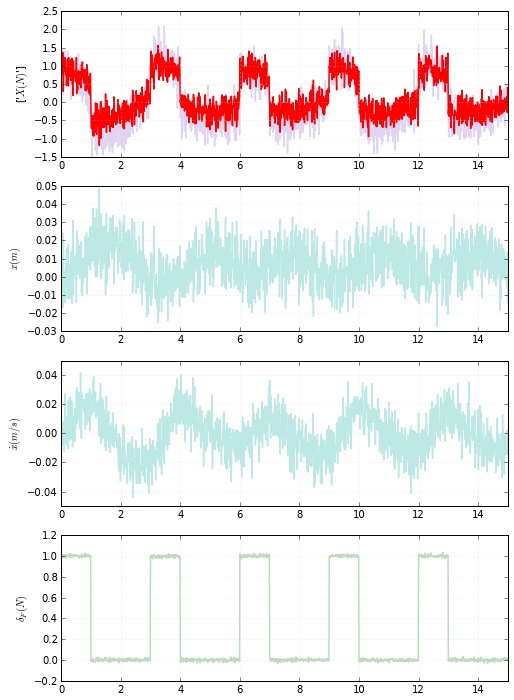

In [74]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe=None, Fe=np.dot(A, C))

Not great. And the estimated system response?

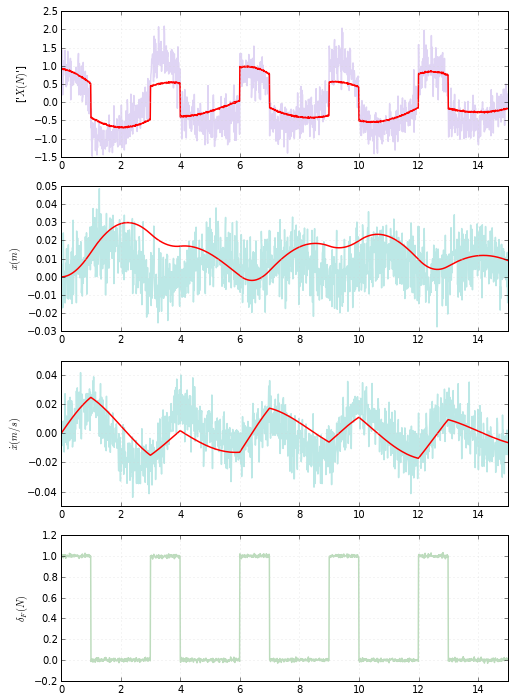

In [75]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe, Fe)

Hopeless! This is primarily due to the fact that the error in the independant variables is introducing bias into the LS estimate.

### Nonlinear (iterative) Gradient-based Estimation

Let's try that again, this time using an iterative technique. We'll use Powell's Method here.

In [62]:
msd_fest = MSD("Mass-Spring-Damper_FMIN_EST")

def objfun(x):
    for i in range(len(c_idx)):
        msd_fest.C[c_idx[i]] = x[i]

    # Compute the response
    Xe, Xedot, Fe = msd_fest.integrate(z0, T, e_func)

    # For fmin, fmin_powell, fmin_bfgs, fmin_l_bfgs_b
    dF = F - Fe
    fopt = np.sum(dF*dF)
    sys.stdout.write("[")
    for i in range(len(c_idx)):
        sys.stdout.write(" %s: %.4f" % (c_idx[i], x[i]))
    sys.stdout.write("] fopt = %.6e\n" % fopt)
    sys.stdout.flush()
    return fopt

# Need to start with a nontrivial parameter set to avoid getting stuck in a local minima straight away...
C = optimize.fmin_powell(objfun, C0)
C = C.reshape((-1, 1))

print
print "            TRUE      F_EST"
for i in range(len(c_idx)):
    print "%5s: %10.4f %10.4f" % (c_idx[i], msd.C[c_idx[i]], np.ravel(C)[i])

for i in range(len(c_idx)):
    msd_fest.C[c_idx[i]] = np.ravel(C)[i]

# Compute the response
Xe, Xedot, Fe = msd_fest.integrate(z0, T, e_func)

[ k: -5.0000 b: -1.0000 d: 0.1000] fopt = 6.347409e+02
[ k: -5.0000 b: -1.0000 d: 0.1000] fopt = 6.347409e+02
[ k: -4.0000 b: -1.0000 d: 0.1000] fopt = 6.348958e+02
[ k: -6.6180 b: -1.0000 d: 0.1000] fopt = 6.329532e+02
[ k: -9.2361 b: -1.0000 d: 0.1000] fopt = 6.289290e+02
[ k: -13.4721 b: -1.0000 d: 0.1000] fopt = 6.265655e+02
[ k: -13.3070 b: -1.0000 d: 0.1000] fopt = 6.265661e+02
[ k: -20.3262 b: -1.0000 d: 0.1000] fopt = 6.253840e+02
[ k: -19.3783 b: -1.0000 d: 0.1000] fopt = 6.260965e+02
[ k: -31.4164 b: -1.0000 d: 0.1000] fopt = 6.089231e+02
[ k: -49.3607 b: -1.0000 d: 0.1000] fopt = 5.807445e+02
[ k: -78.3951 b: -1.0000 d: 0.1000] fopt = 5.512612e+02
[ k: -106.8643 b: -1.0000 d: 0.1000] fopt = 3.988342e+02
[ k: -152.9285 b: -1.0000 d: 0.1000] fopt = 1.033998e+03
[ k: -106.8643 b: -1.0000 d: 0.1000] fopt = 3.988342e+02
[ k: -124.4593 b: -1.0000 d: 0.1000] fopt = 5.525858e+02
[ k: -95.9901 b: -1.0000 d: 0.1000] fopt = 4.540821e+02
[ k: -105.8457 b: -1.0000 d: 0.1000] fopt = 4.005

Much better! Although it did take some time. And the system response is quite good too.

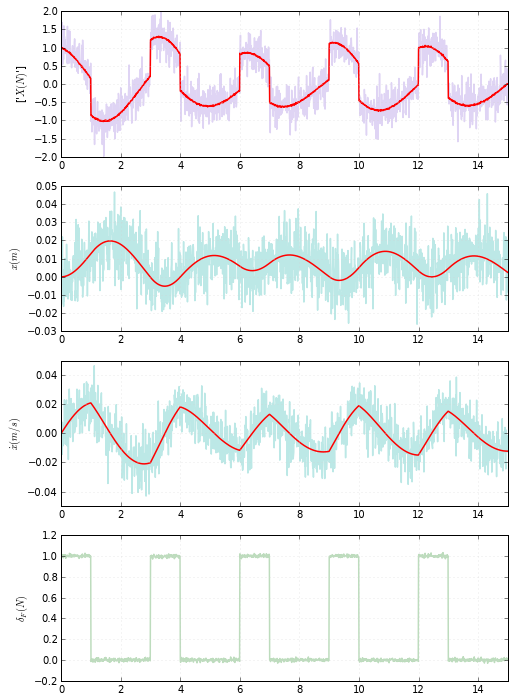

In [63]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe, Fe)

Other methods (from the SciPy Optimisation Library) that work just as well include BFGS, and nonlinear Least-Squares.